## Directory Structure
PLEASE make sure your directory looks like this:
- root_dir
    - pixel-nerf (clone/pull from github)
    - adaptive-volume-rendering (clone/pull from github)
        - 6S980_Project.ipynb
    - scene-representation-networks (clone/pull from github)
    - data
    - checkpoints
    - ......
    
Then set your pwd to root_dir

## Relevant Repos

- PixelNeRF repo: https://github.com/sxyu/pixel-nerf

- SRN repo: https://github.com/vsitzmann/scene-representation-networks

- SRN raymarcher algorithm: https://github.com/vsitzmann/scene-representation-networks/blob/master/custom_layers.py

## Data

- Currently using cars dataset from SRN

## What we did

- Yanke: Debug is finished.


## TODO
- Need to incorporate input ray directions.
- Now normal renderer is just simple evenly sample. Need to add importance weighting later.

In [1]:
root_dir = "/Users/yankesong/Documents/YankeSong/Harvard Textbook/MIT 6.S980/Project/"       # This is the only thing you need to change.
%cd "/Users/yankesong/Documents/YankeSong/Harvard Textbook/MIT 6.S980/Project/"

# root_dir = "/Users/jameszli/desktop/MIT/6.S980/"       # This is the only thing you need to change.
# %cd "/Users/jameszli/desktop/MIT/6.S980/"

/Users/yankesong/Documents/YankeSong/Harvard Textbook/MIT 6.S980/Project


In [2]:
# Install everything
%pip install -r adaptive-volume-rendering/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import everything
import sys

sys.path.insert(0, f"{root_dir}/scene-representation-networks/")
sys.path.insert(0, f"{root_dir}/pixel-nerf/src/")
sys.path.insert(0, f"{root_dir}/adaptive-volume-rendering/")

from dataset import *
from models import *
from renderers import *
from trains import *
from utils import *
from model import make_model, loss

print(f"Installed Torch version: {torch.__version__}")

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(device)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Installed Torch version: 1.13.0
cpu


## Setup & Load Test Data

In [4]:
# Download data and weights

# Make a new directory
!mkdir data
!mkdir checkpoints

# Download Test Dataset
if not os.path.exists(f"{root_dir}data/cars_train.hdf5"):
    # Download SRNs-cars dataset
    gdown.download("https://drive.google.com/uc?id={}".format("1SBjlsizq0sFNkCZxMQh-pNRi0HyFozKb"),f"{root_dir}data/cars_train.hdf5")

# View test image
# sl = 64
# dataset = SRNsCars(root_dir,img_sidelength=sl)
# mi, rgb = next(iter(dataset))

# rgb = rgb.reshape(sl, sl, 3).view()

# plt.imshow(rgb)
# plt.show()

# print("Cam2world ", mi['cam2world'])
# print("Intrinsics ", mi['intrinsics'])
# print("Pixel coords shape", mi['x_pix'].shape, mi['x_pix'].max())
# print("Scene idx", mi['idx'])

## Download pretrained weights from PixelNeRF
if not os.path.exists(f"{root_dir}checkpoints/pixel_nerf_weights.zip"):
  gdown.download("https://drive.google.com/uc?id={}".format("1UO_rL201guN6euoWkCOn-XpqR2e8o6ju"),f"{root_dir}checkpoints/pixel_nerf_weights.zip")
  !unzip checkpoints/pixel_nerf_weights.zip -d checkpoints/

mkdir: data: File exists
mkdir: checkpoints: File exists


## Renderer

Loading PixlNeRF models

- The volume renderer is in src/nerf.py
- Can easily wrap a net with a renderer using _RenderWrapper function
- The current volume renderer samples points in the following way:
  - Sample 64 coarse points (uniform sample)
  - Sample 16 fine points (importance sample, still need to check how)
  - Compute an expected depth, then sample 16 random normal points with sd=0.01 around that depth.

In [5]:
# Create a custom conf
from pyhocon import ConfigFactory
conf = ConfigFactory.parse_file(f"adaptive-volume-rendering/conf/default_mv.conf")

# Create a pixelnerf net
net = make_new_model(conf["model"]).to(device=device)
net.stop_encoder_grad = True

# Combine with volumerenderer
renderer = VolumeRenderer.from_conf(conf["normal_renderer"]).to(
    device=device
)

rf_and_renderer = RadFieldAndRenderer(net, renderer).to(device=device)

Using torchvision resnet34 encoder


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0
Step 0: loss = 0.31523


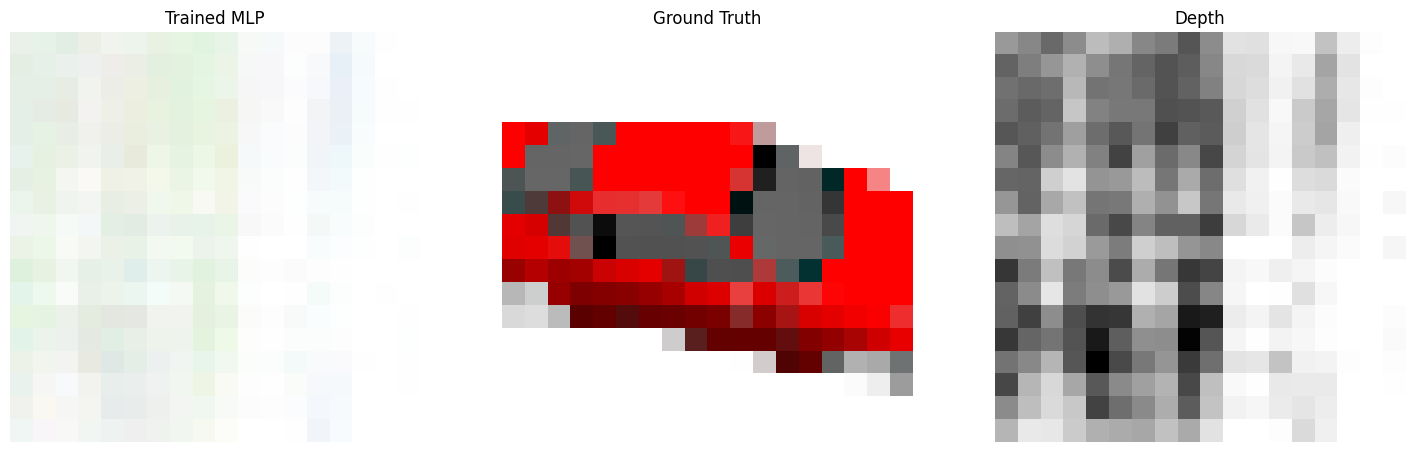

1
2
3
4
5
6
7
8
9
10
Step 10: loss = 0.20445


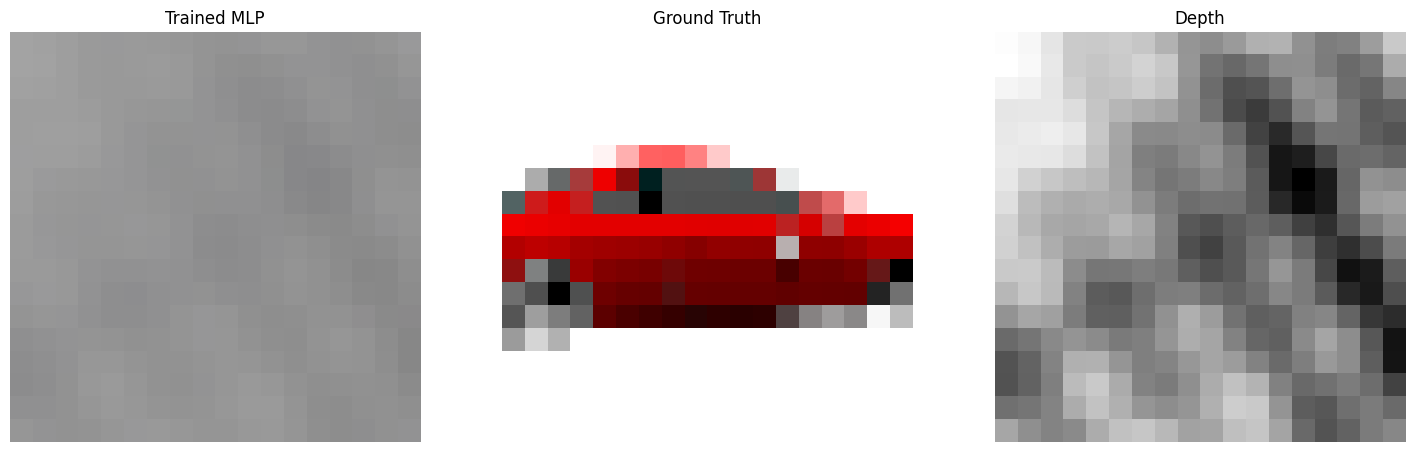

11
12
13
14
15
16
17
18
19
20
Step 20: loss = 0.18272


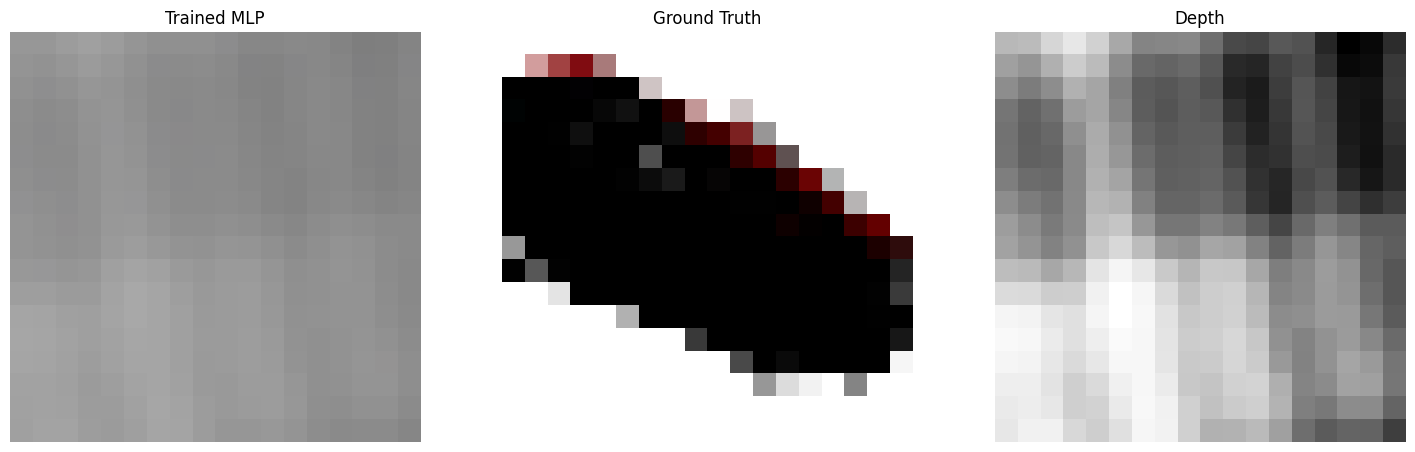

21
22
23
24
25
26
27
28
29
30
Step 30: loss = 0.18232


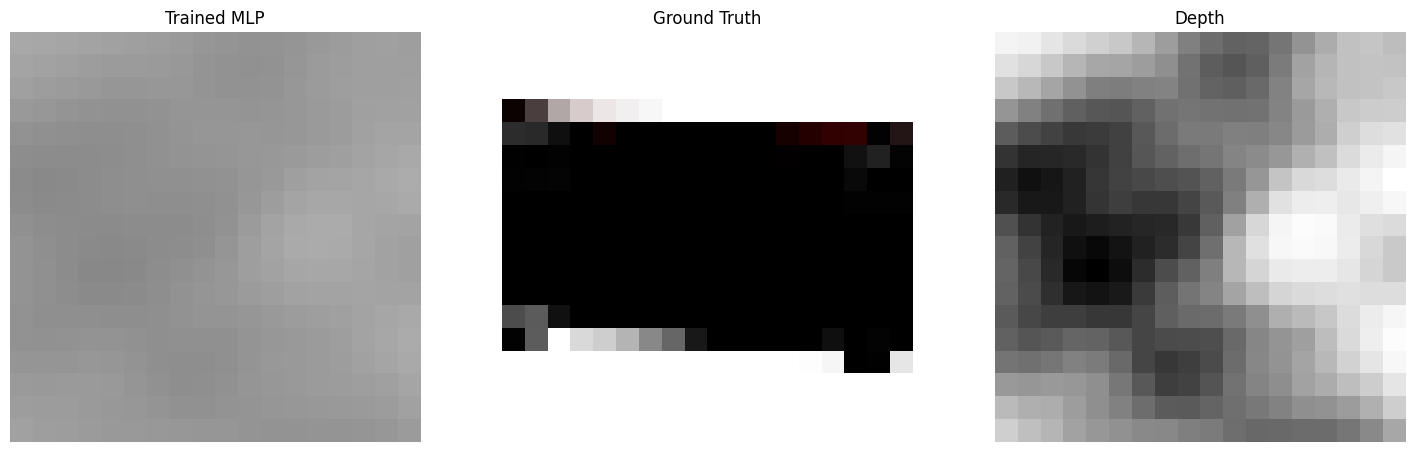

31
32
33
34
35
36
37
38
39
40
Step 40: loss = 0.16353


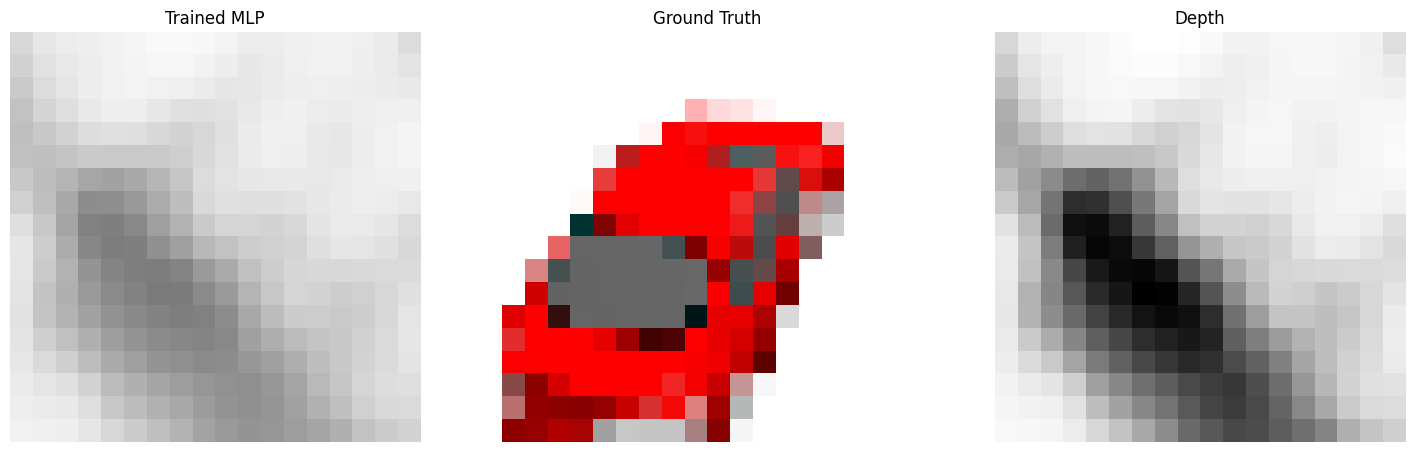

41
42
43
44
45
46
47
48
49
50
Step 50: loss = 0.15023


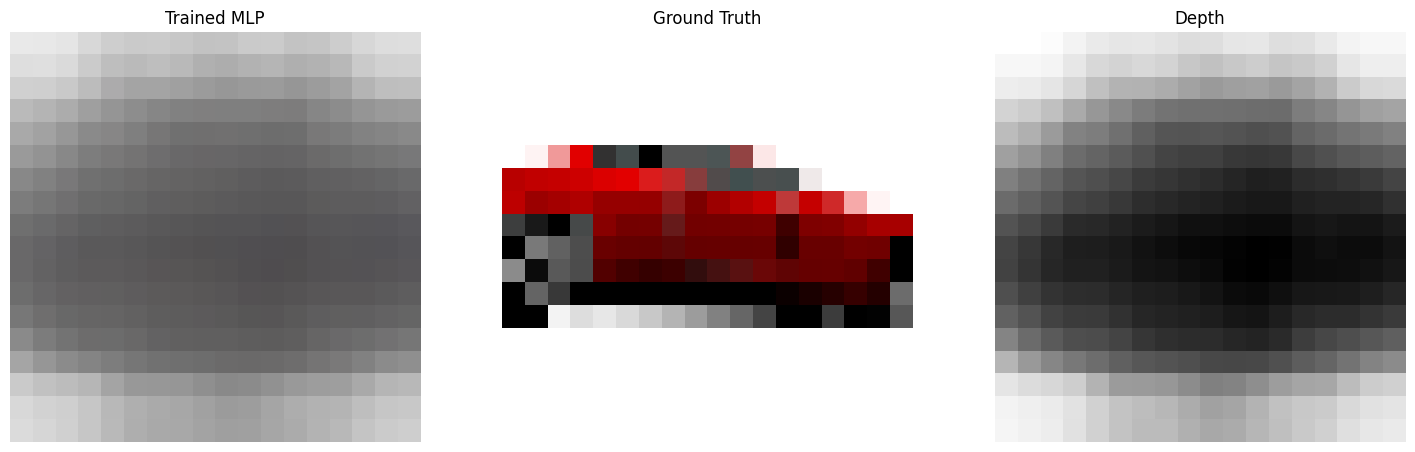

51
52
53
54
55
56
57
58
59
60
Step 60: loss = 0.18404


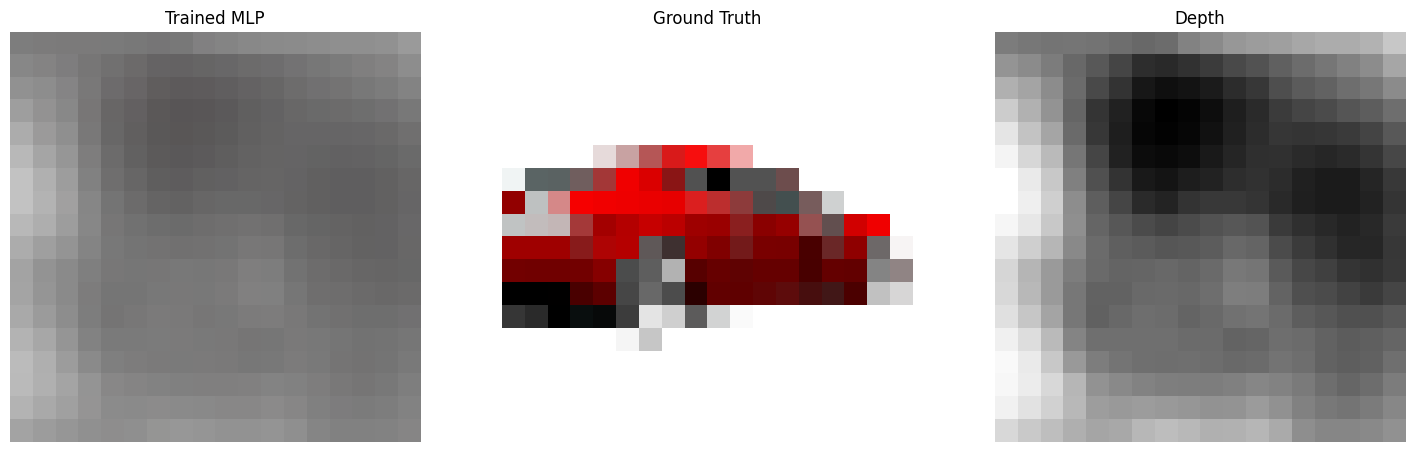

61
62
63
64
65
66
67
68
69
70
Step 70: loss = 0.13475


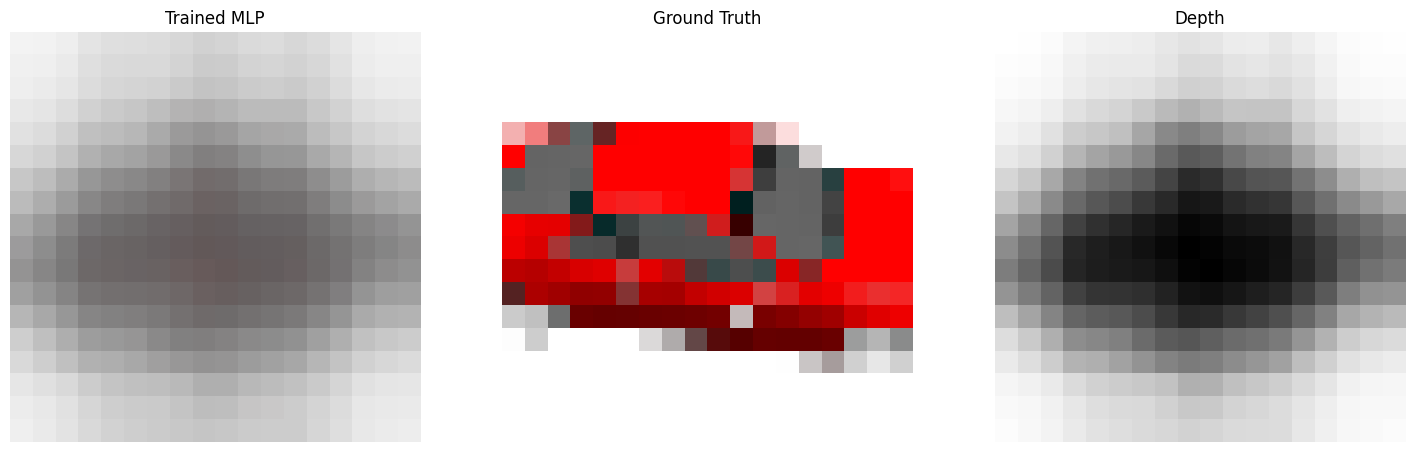

71
72
73
74
75
76
77
78
79
80
Step 80: loss = 0.18240


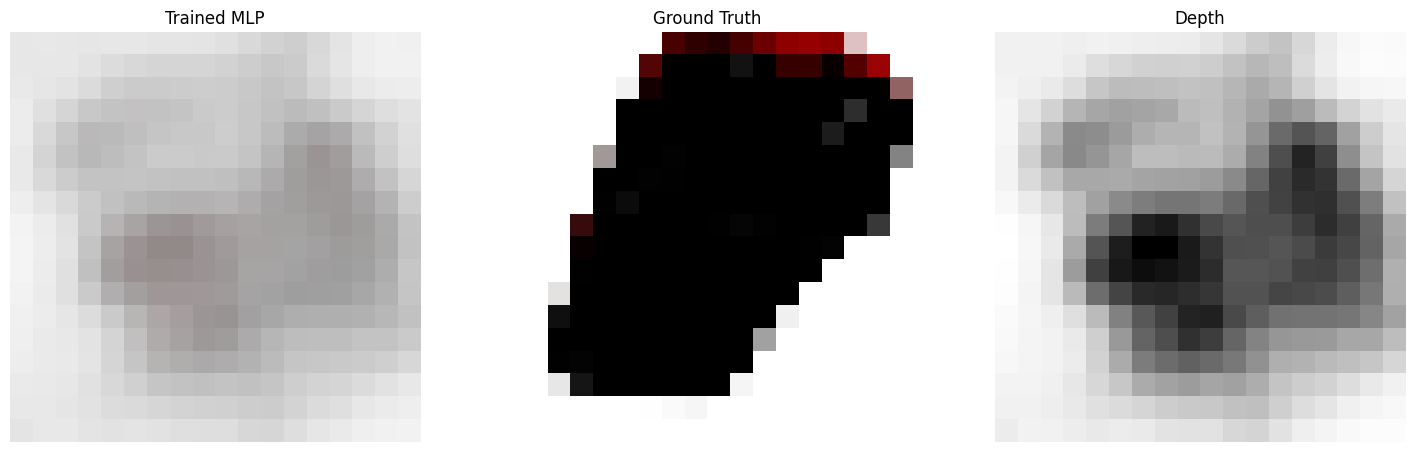

81
82
83
84
85
86
87
88
89
90
Step 90: loss = 0.13375


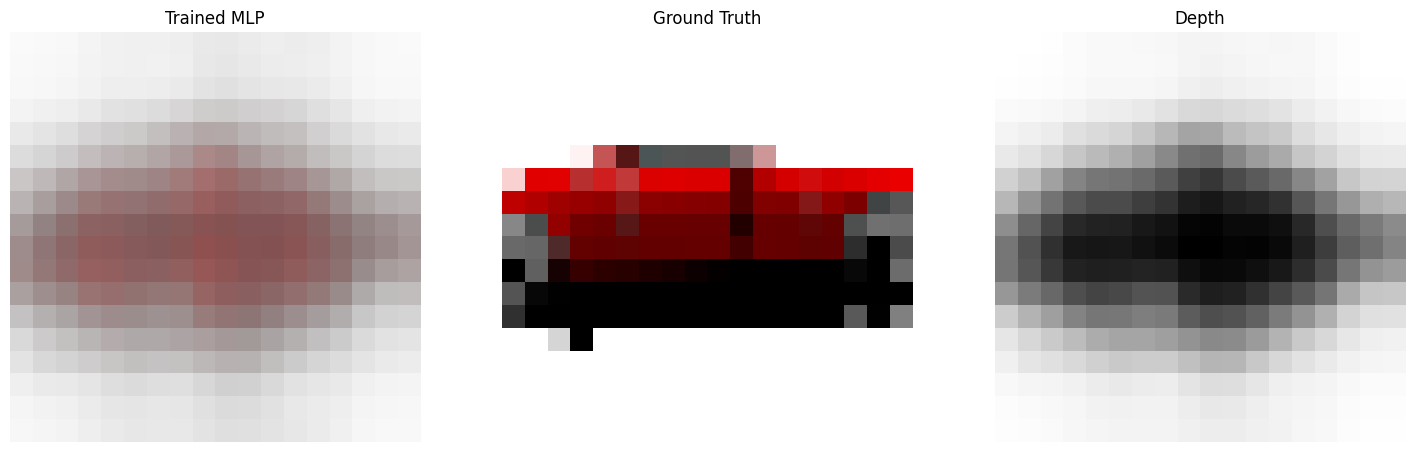

91
92
93
94
95
96
97
98
99
100
Step 100: loss = 0.12725


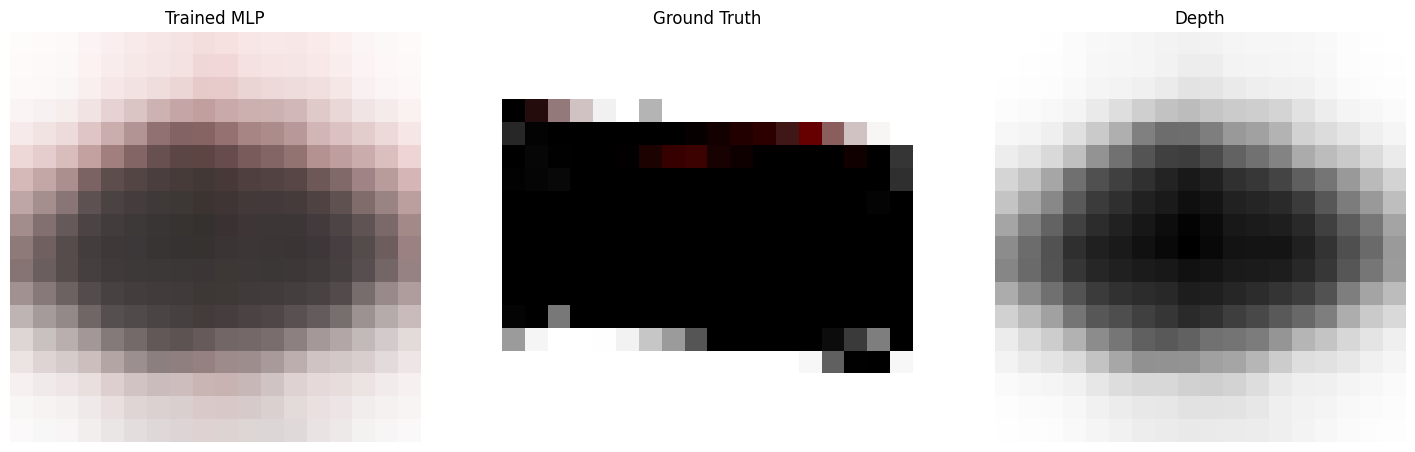

101
102
103
104
105
106
107
108
109
110
Step 110: loss = 0.14649


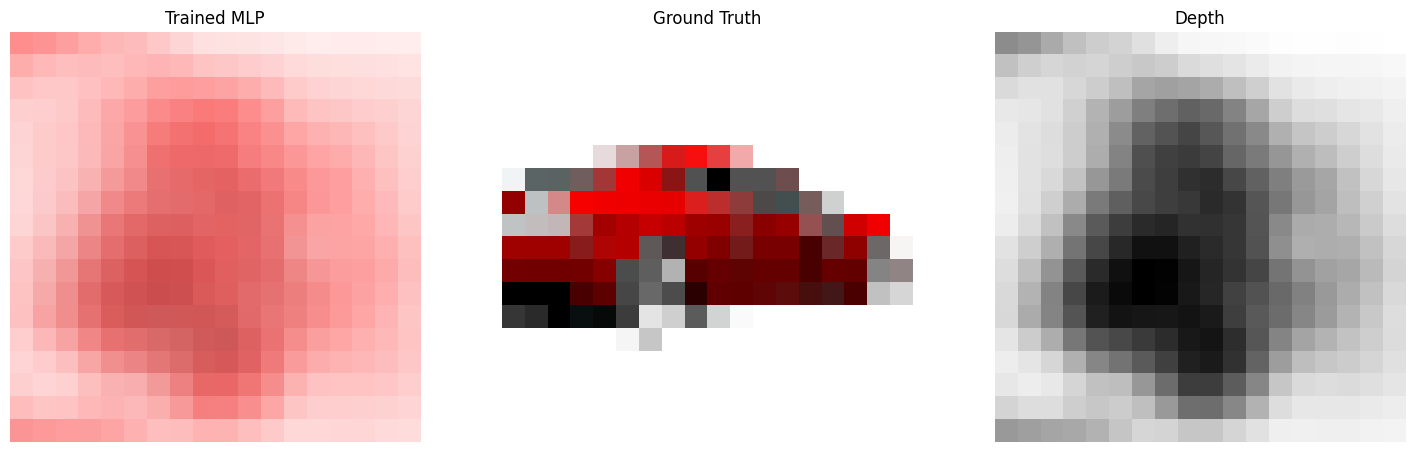

111
112
113
114
115
116
117
118
119
120
Step 120: loss = 0.18348


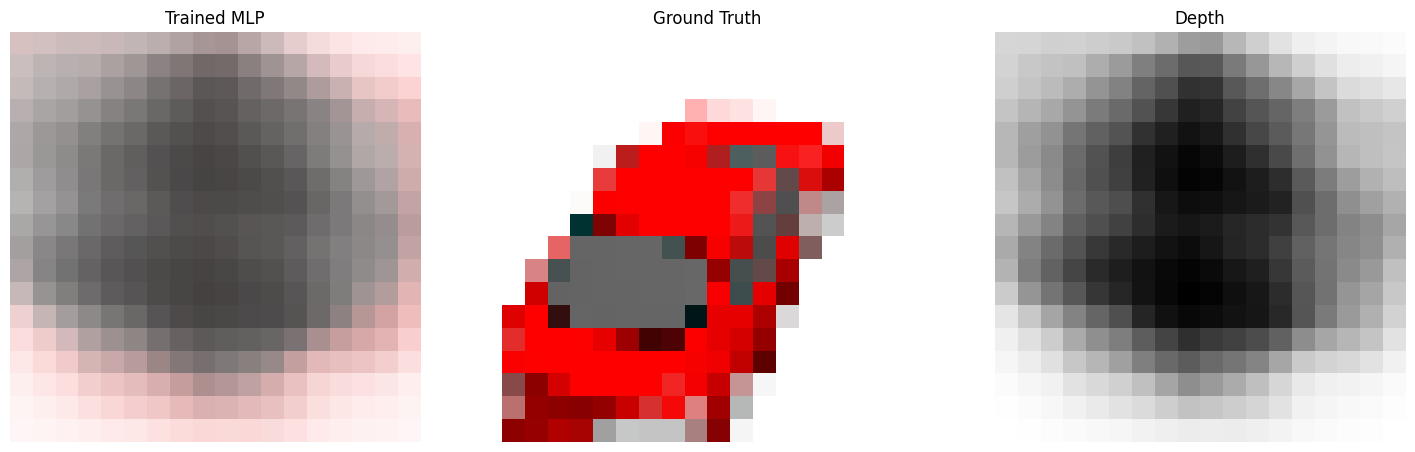

121
122
123
124
125
126
127
128
129
130
Step 130: loss = 0.14408


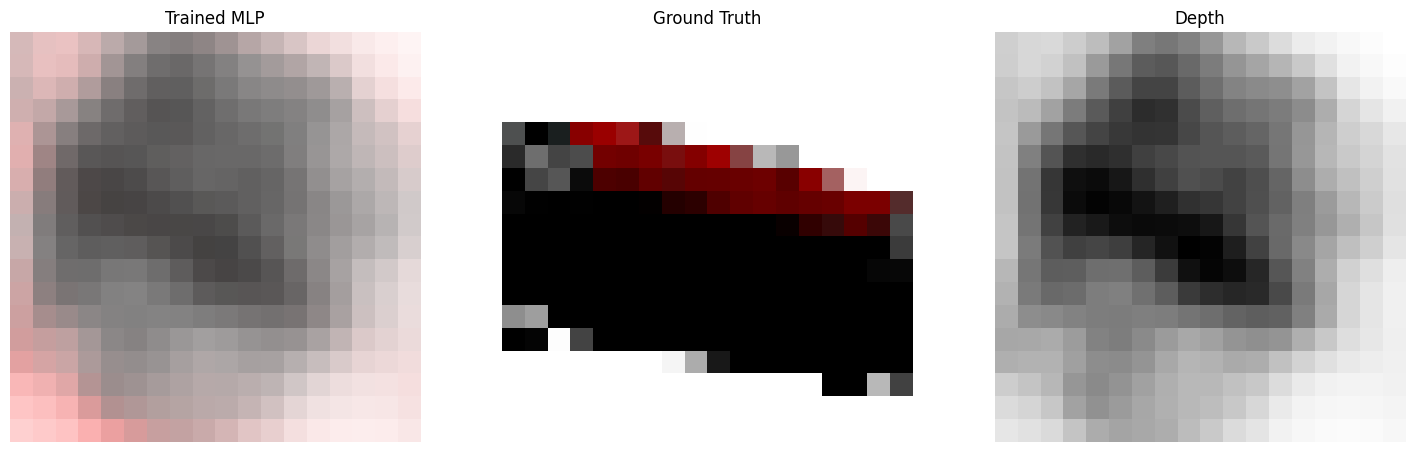

131
132
133
134
135
136
137
138
139
140
Step 140: loss = 0.09708


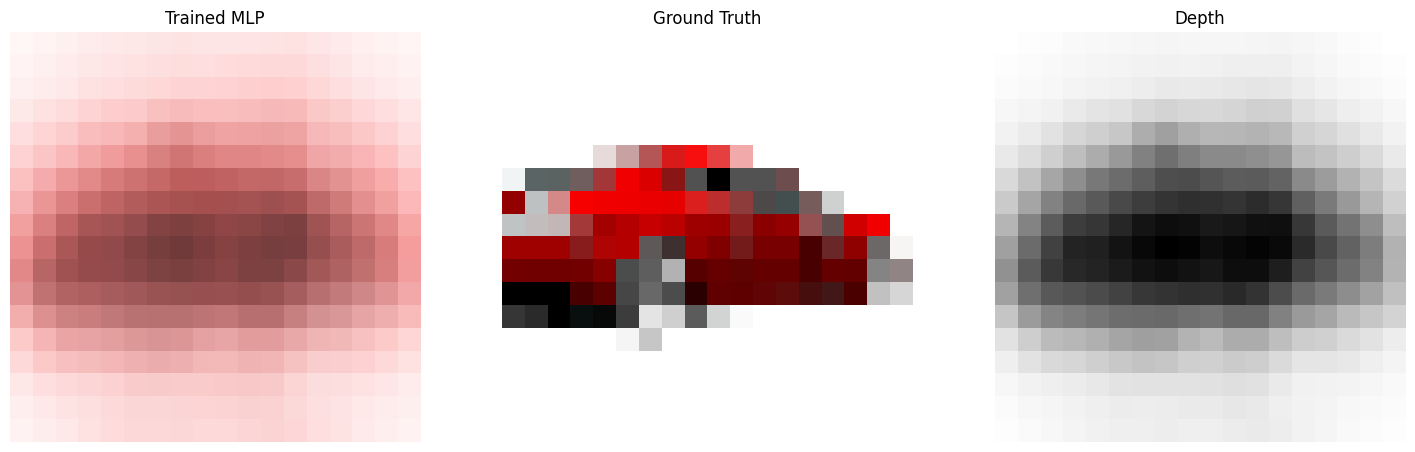

141
142
143
144
145
146
147
148
149
150
Step 150: loss = 0.15027


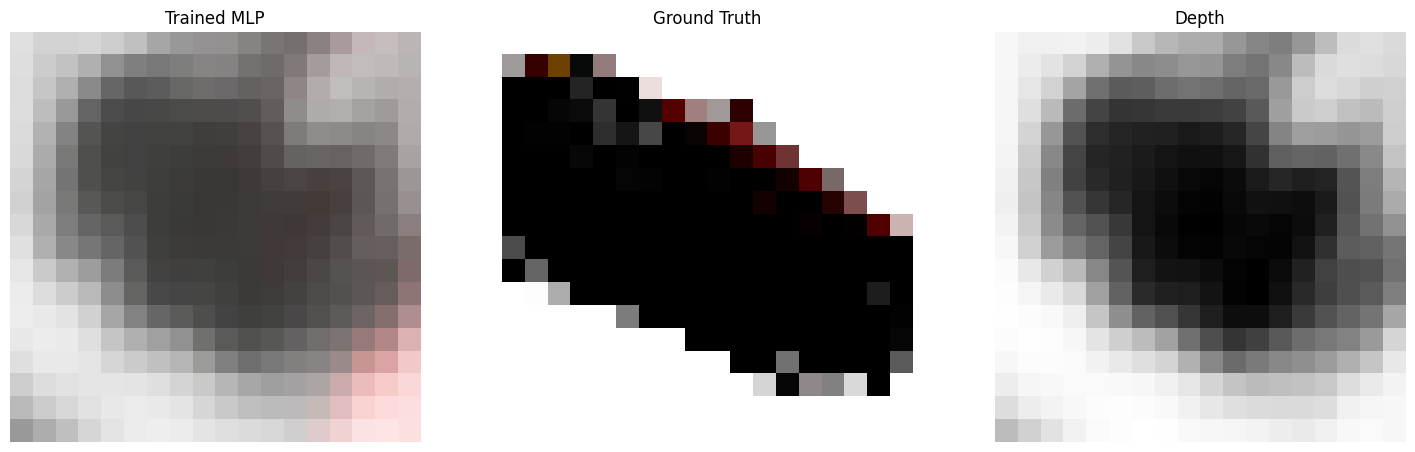

151
152
153
154
155
156
157
158
159
160
Step 160: loss = 0.11873


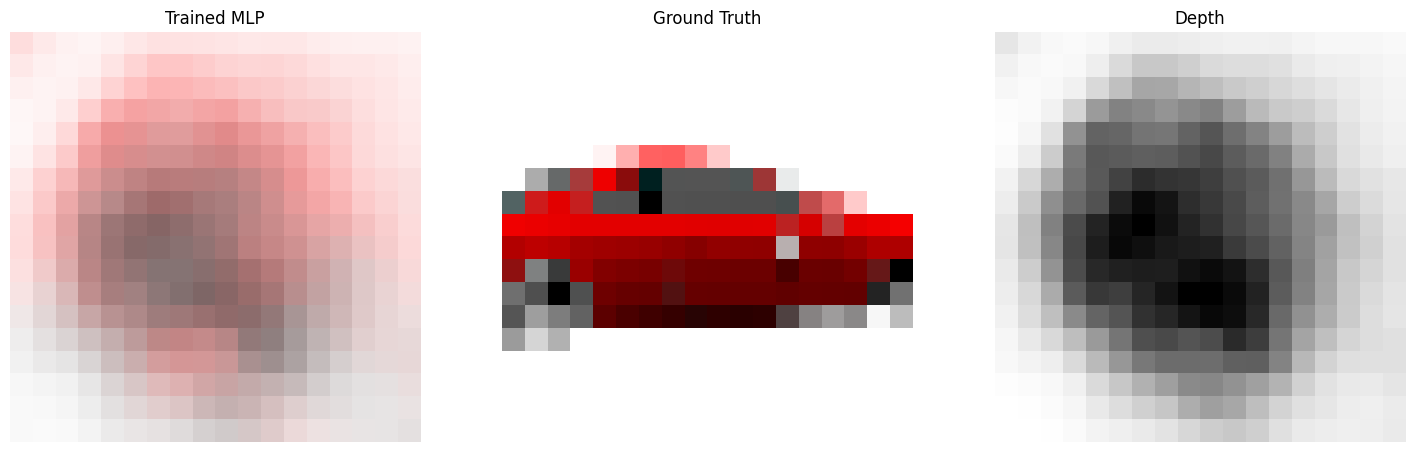

161
162
163
164
165
166
167
168
169
170
Step 170: loss = 0.09625


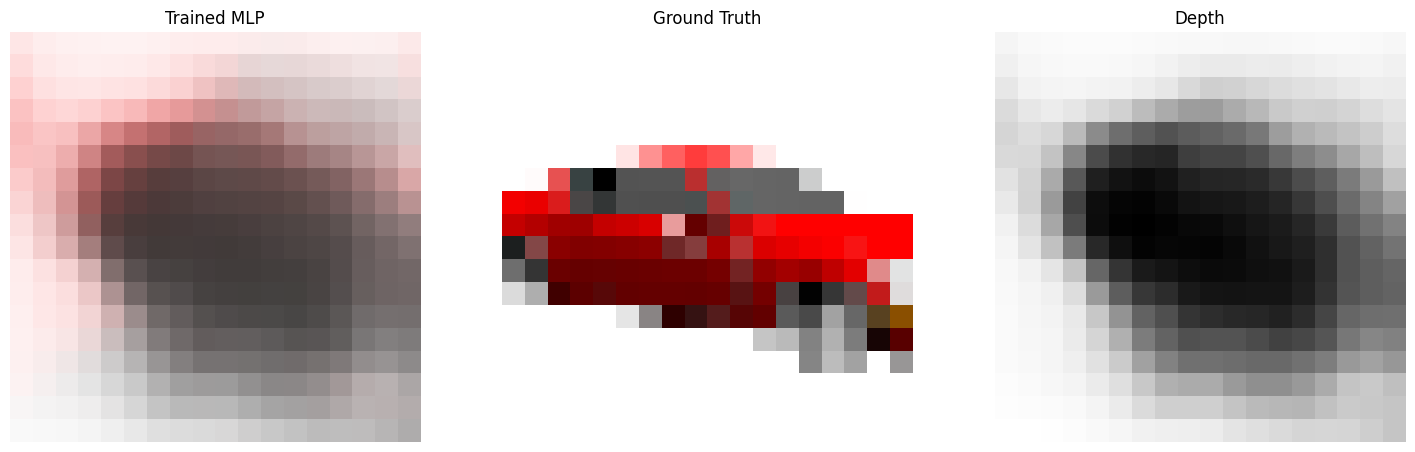

171
172
173
174
175
176
177
178
179
180
Step 180: loss = 0.15636


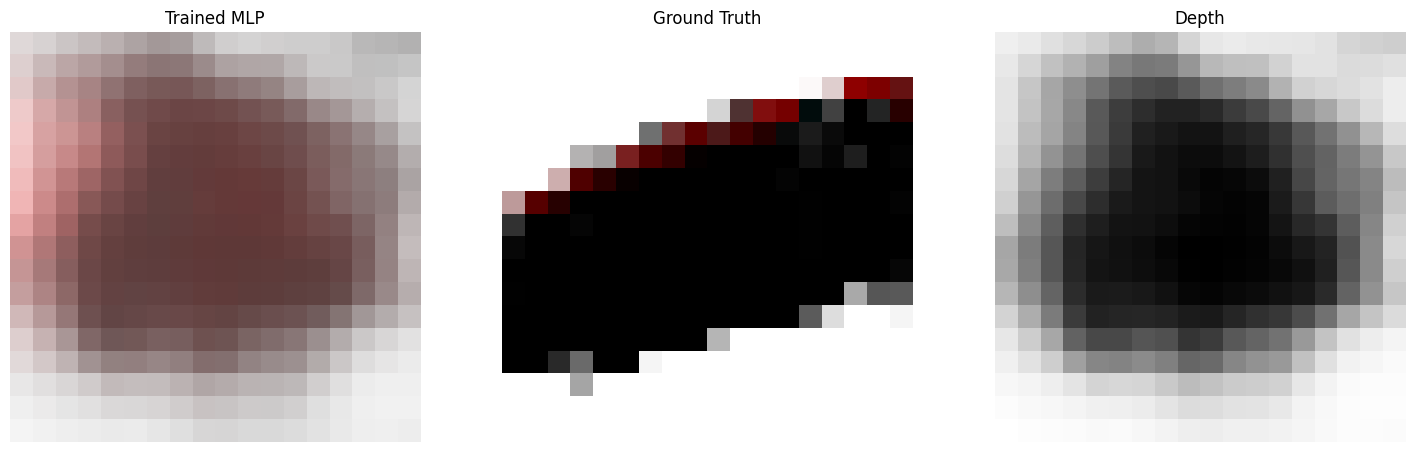

181
182
183
184
185
186
187
188
189
190
Step 190: loss = 0.10408


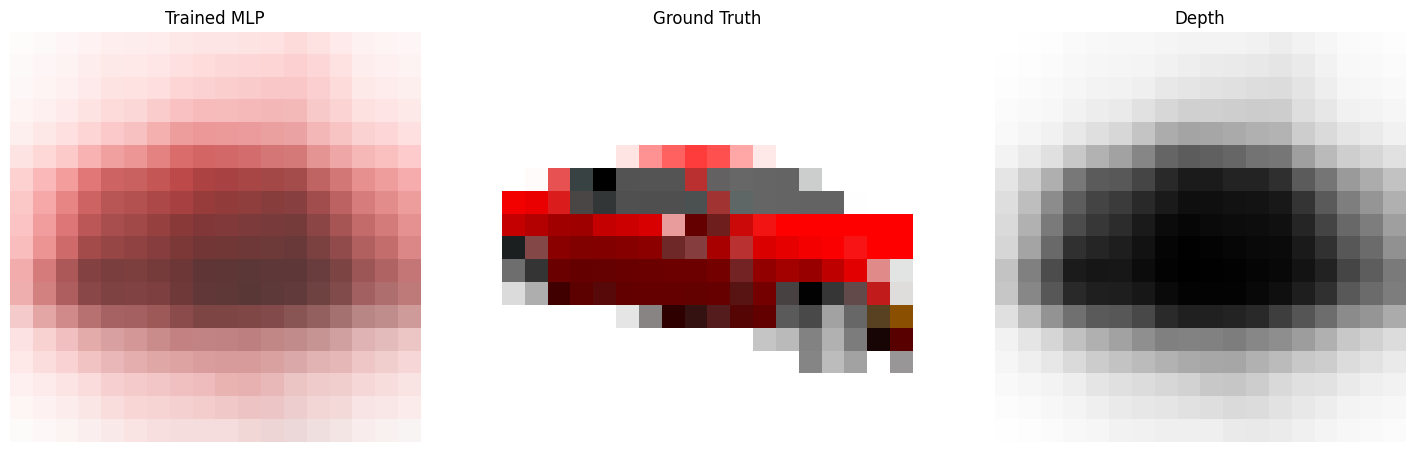

191
192
193
194
195
196
197
198
199
200
Step 200: loss = 0.11718


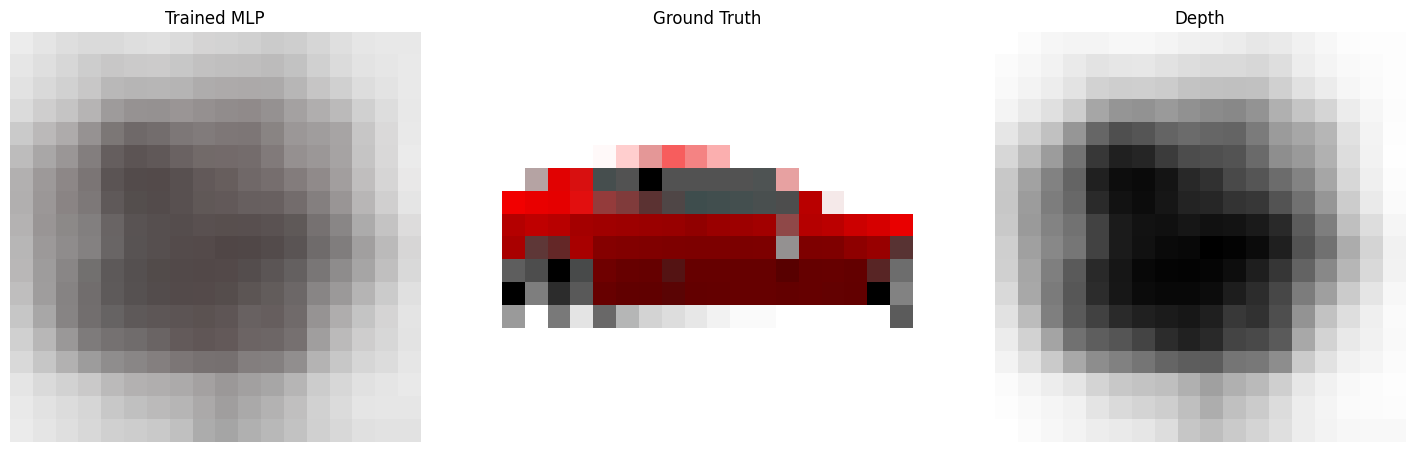

201
202
203
204
205
206
207
208
209
210
Step 210: loss = 0.12780


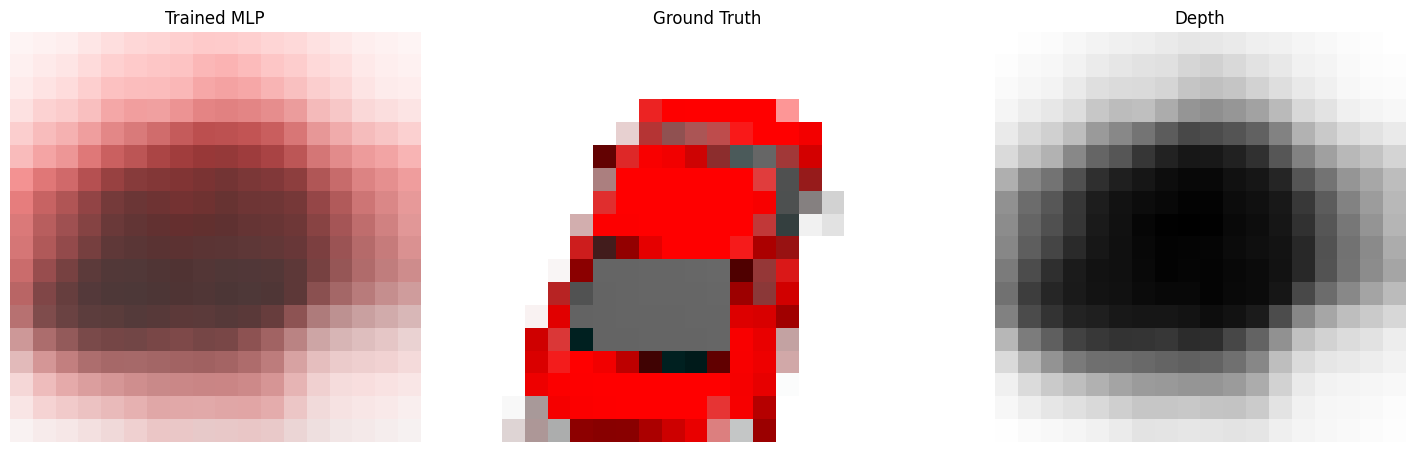

211
212
213
214
215
216
217
218
219
220
Step 220: loss = 0.10998


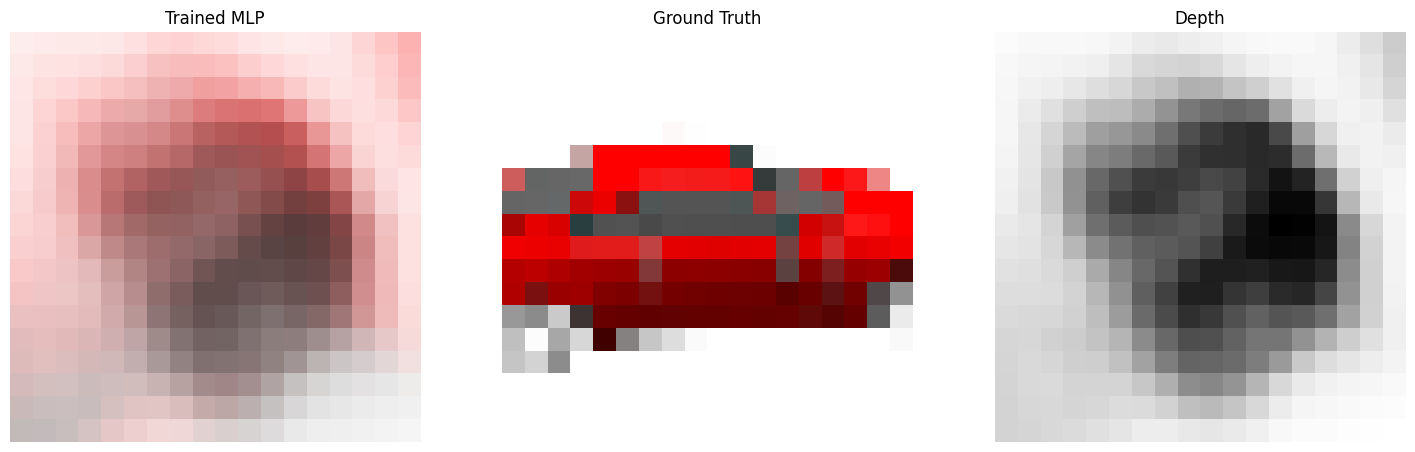

221
222
223
224
225
226
227
228
229
230
Step 230: loss = 0.18897


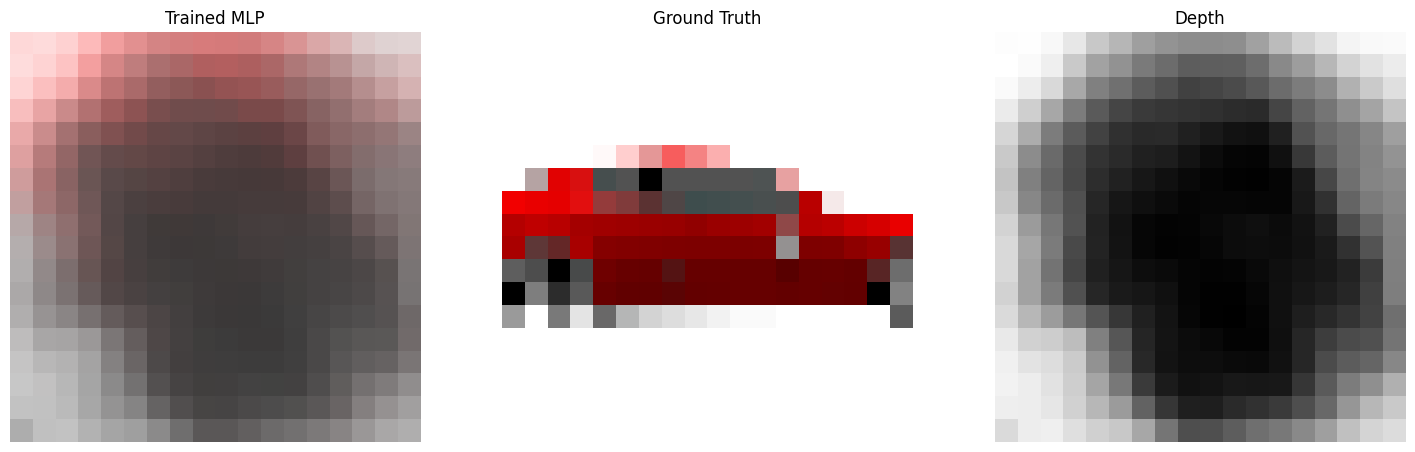

231
232
233
234
235
236
237
238
239
240
Step 240: loss = 0.10730


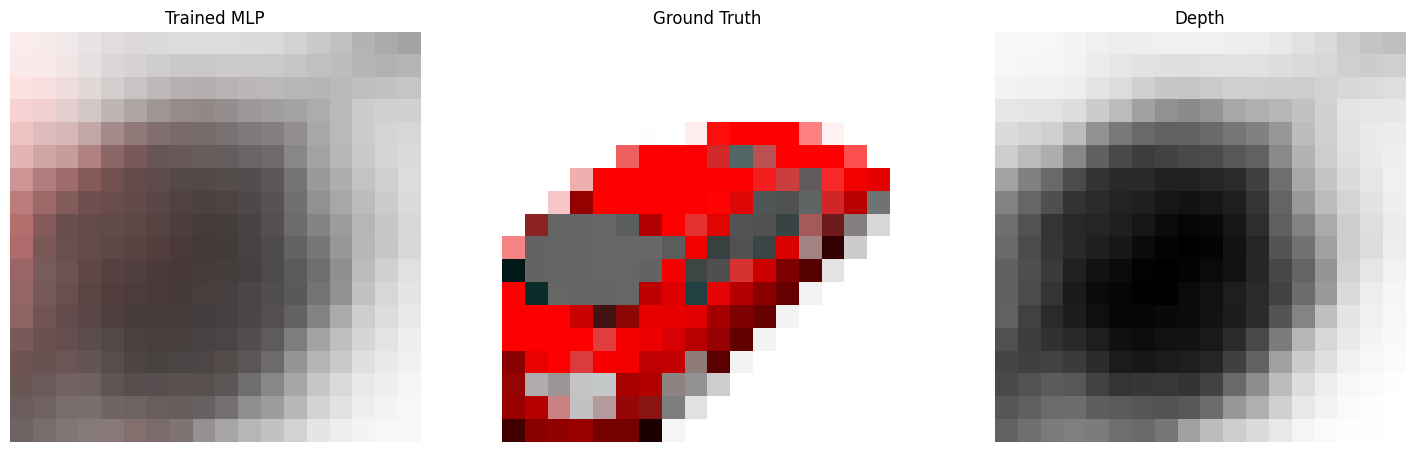

241
242
243
244
245
246
247
248
249
250
Step 250: loss = 0.11468


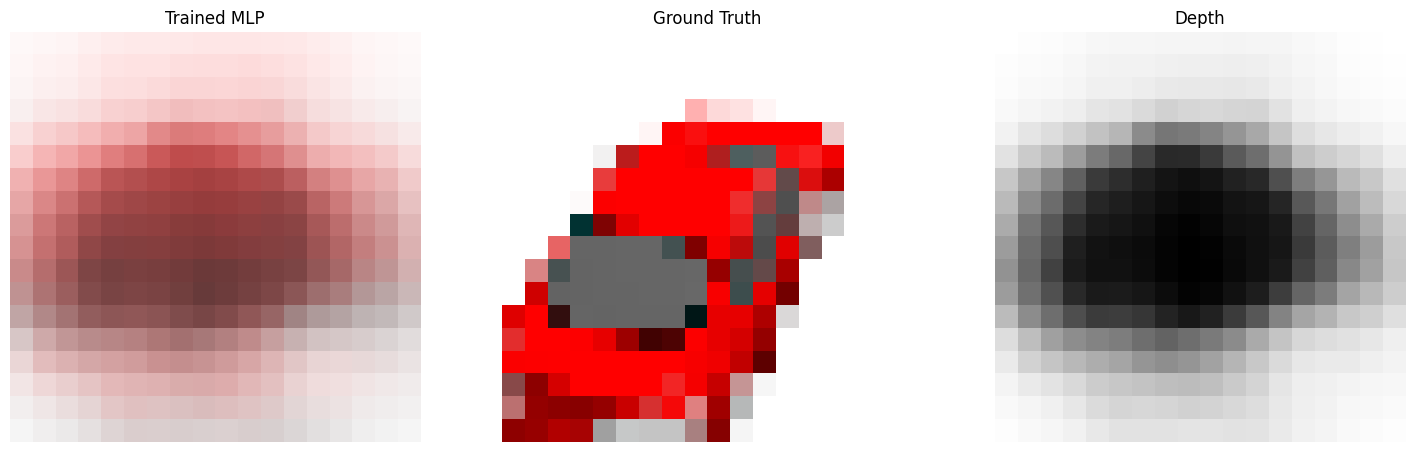

251
252
253
254
255
256
257
258
259
260
Step 260: loss = 0.13485


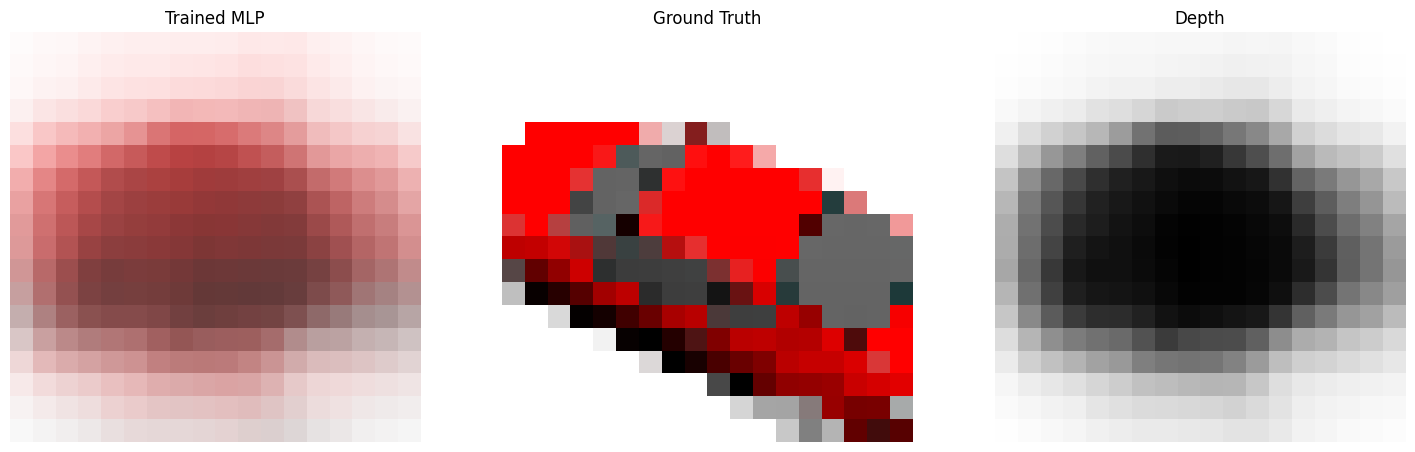

261
262
263
264
265
266
267
268
269
270
Step 270: loss = 0.10075


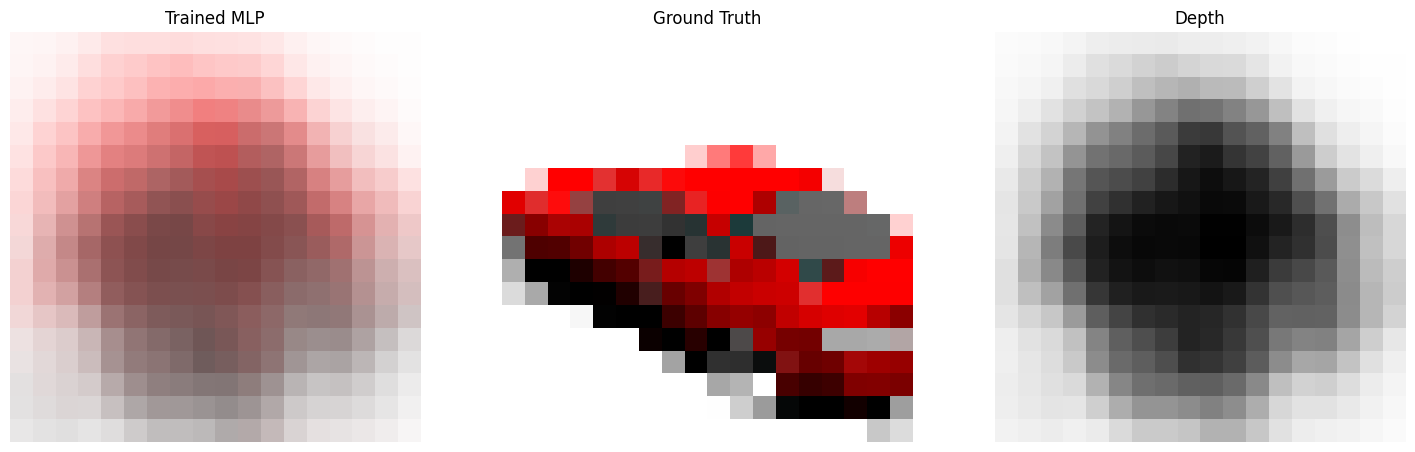

271
272
273
274
275
276
277
278
279
280
Step 280: loss = 0.13655


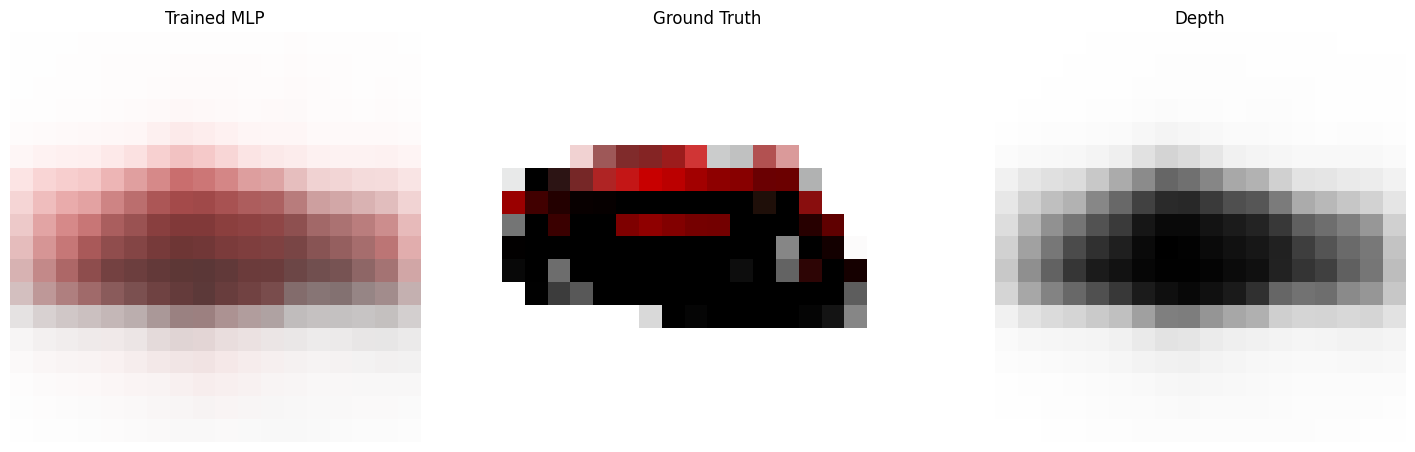

281
282
283
284
285
286
287
288
289
290
Step 290: loss = 0.12313


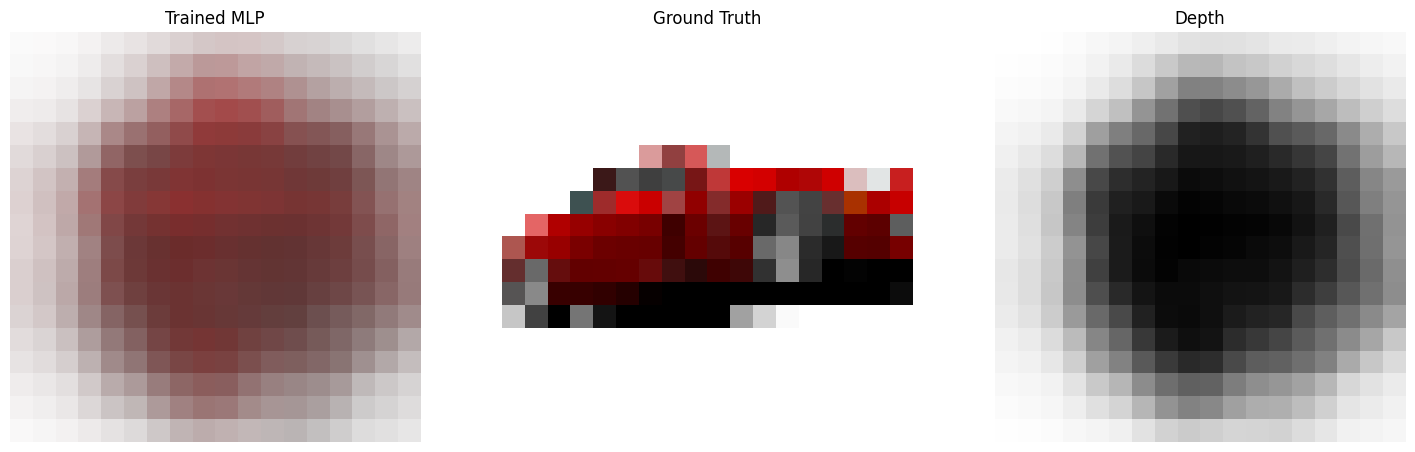

291
292
293
294
295
296
297
298
299
300
Step 300: loss = 0.10205


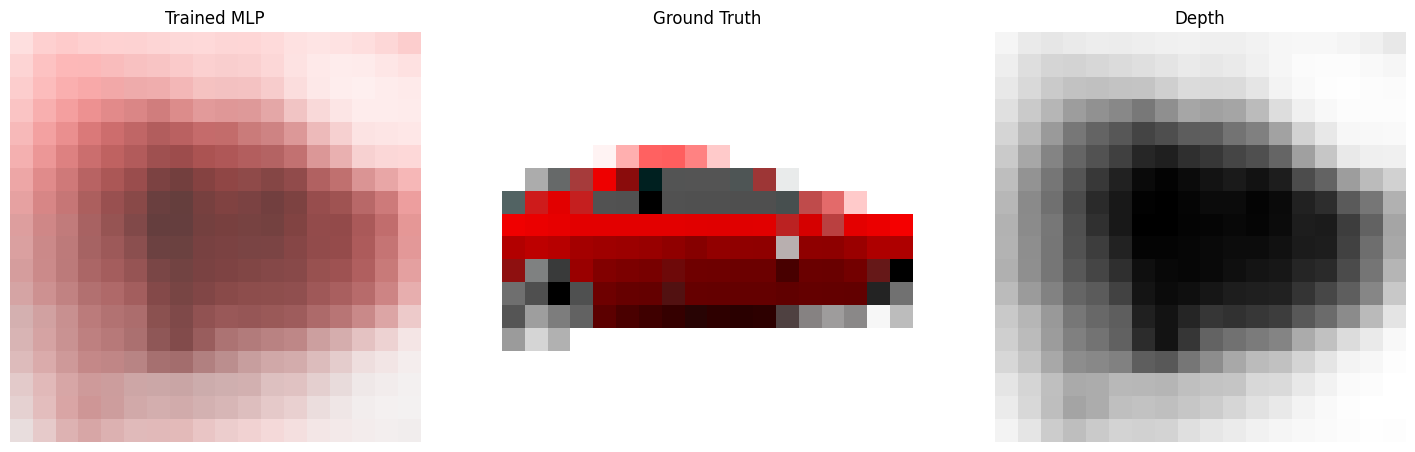

301
302
303
304
305
306
307
308
309
310
Step 310: loss = 0.11863


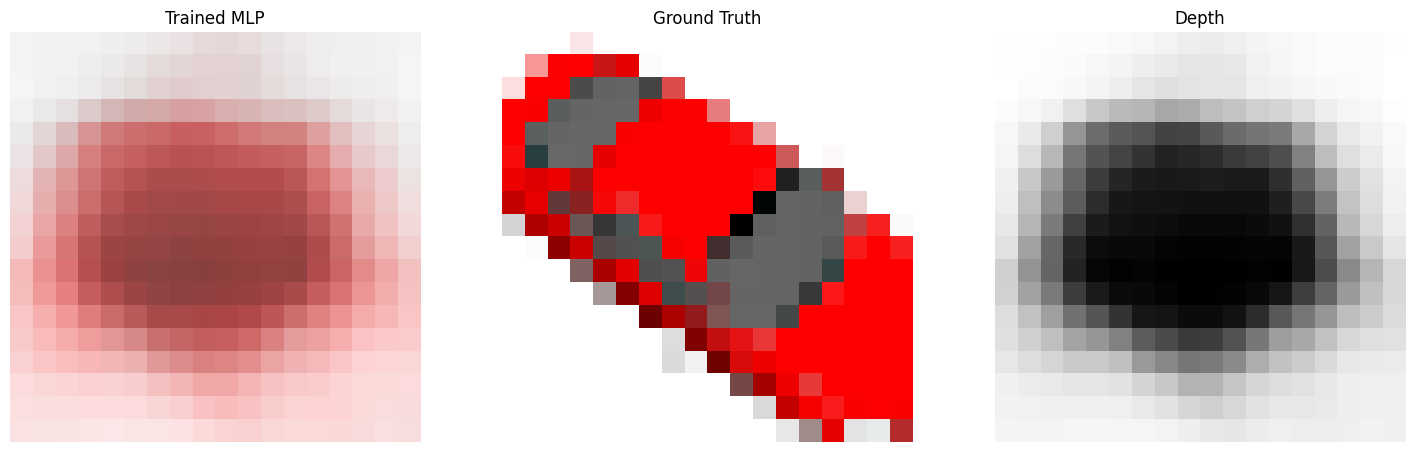

311
312
313
314
315
316
317
318
319
320
Step 320: loss = 0.12352


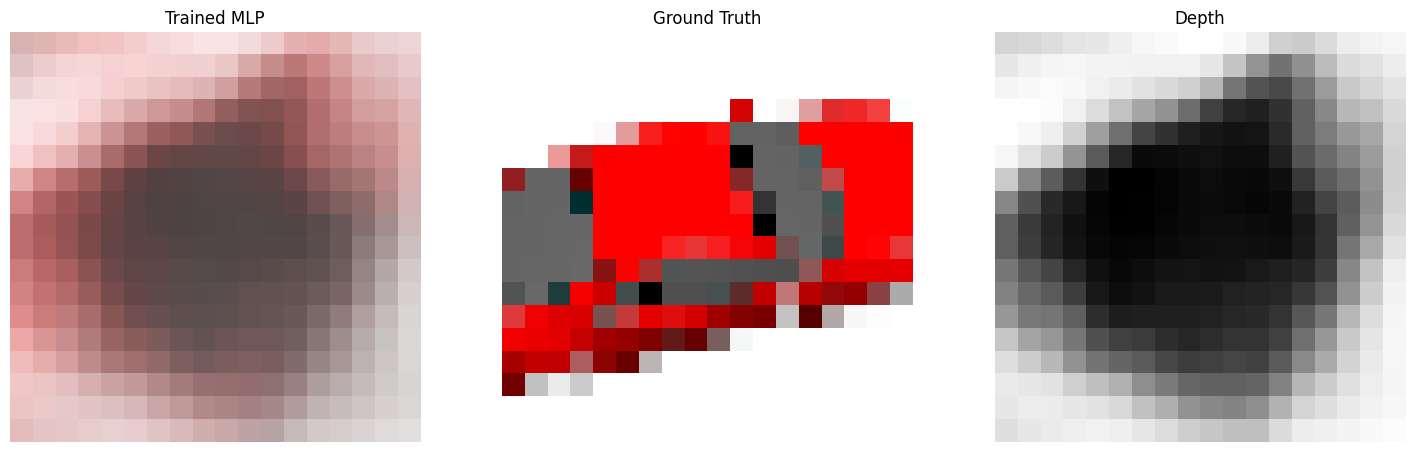

321
322
323
324
325
326
327
328
329
330
Step 330: loss = 0.14420


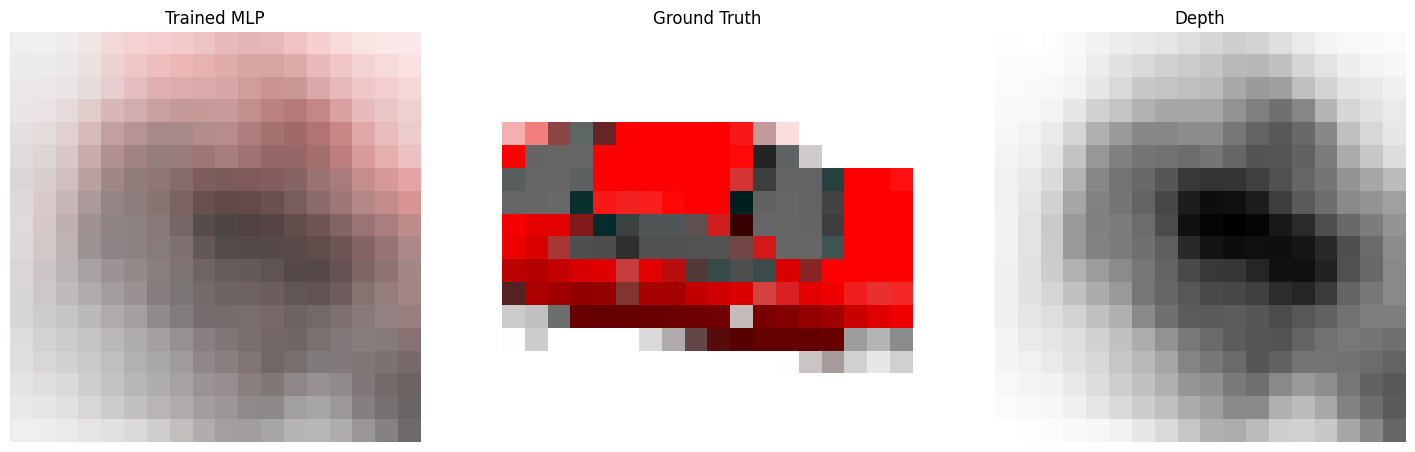

331
332
333
334
335
336
337
338
339
340
Step 340: loss = 0.13757


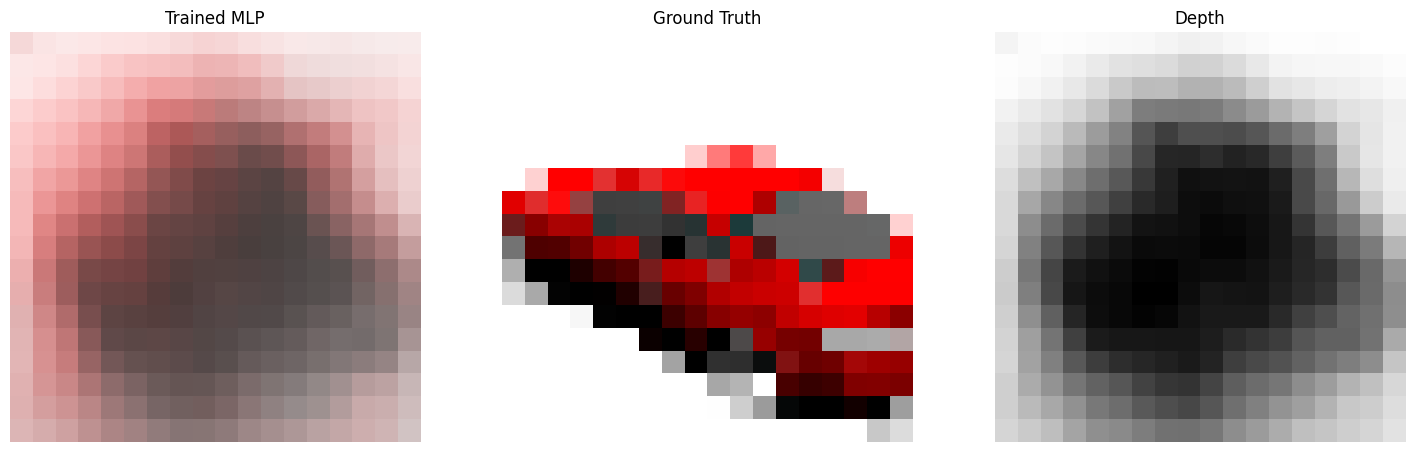

341
342
343
344
345
346
347
348
349
350
Step 350: loss = 0.13489


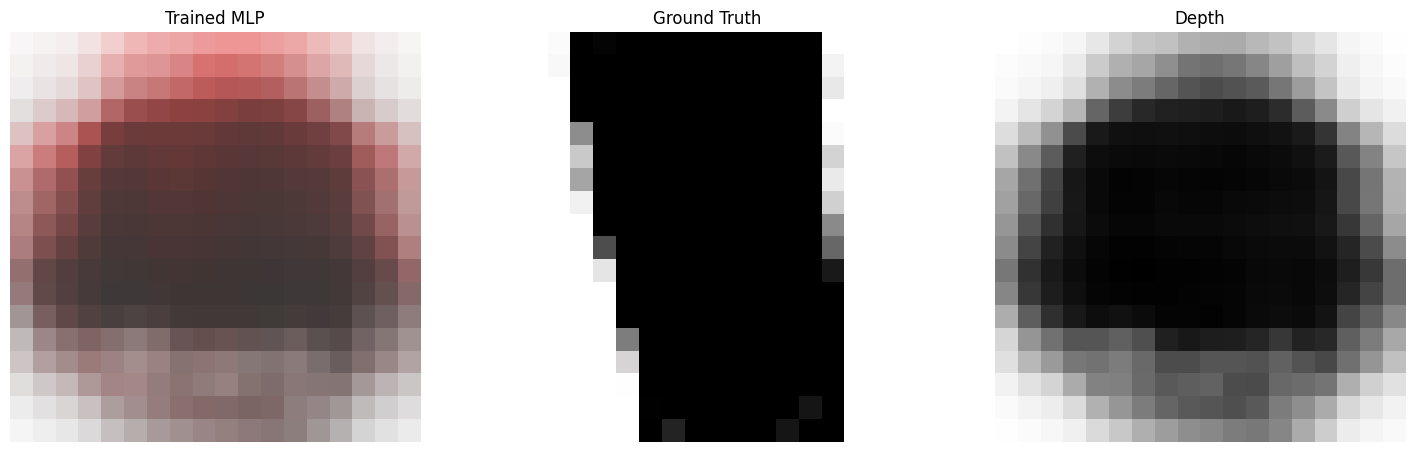

351
352
353
354
355
356
357
358
359
360
Step 360: loss = 0.12498


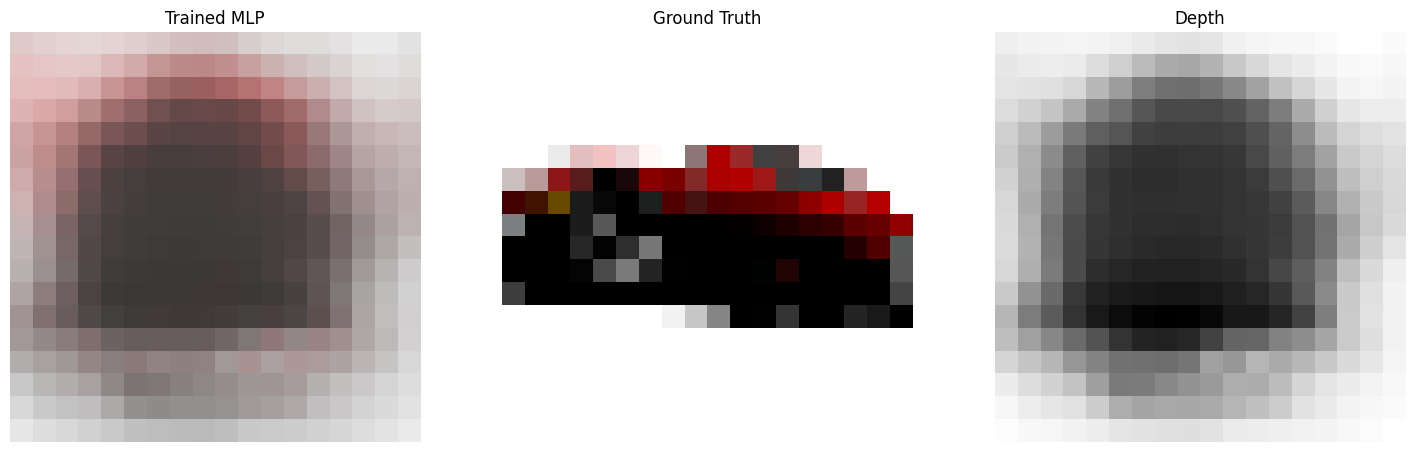

361
362
363
364
365
366
367
368
369
370
Step 370: loss = 0.11659


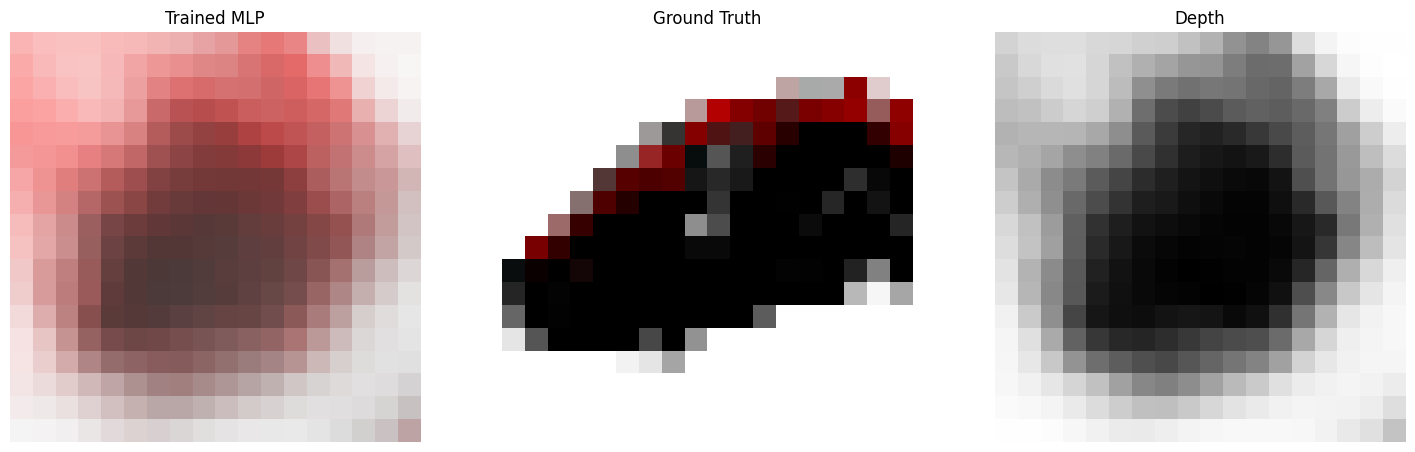

371
372
373
374
375
376
377
378
379
380
Step 380: loss = 0.11045


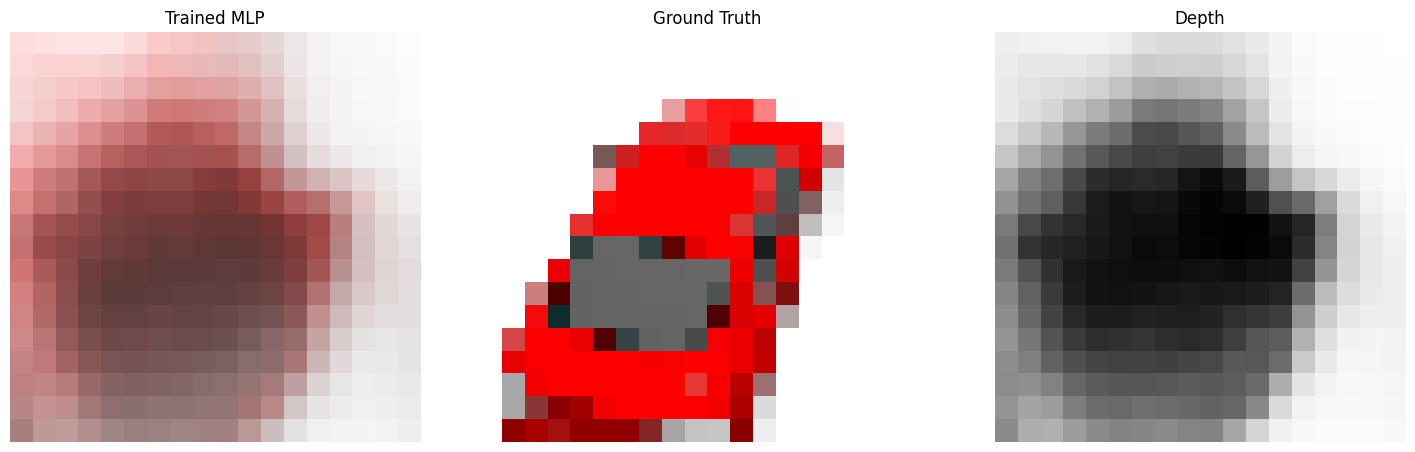

381
382
383
384
385
386
387
388
389
390
Step 390: loss = 0.09468


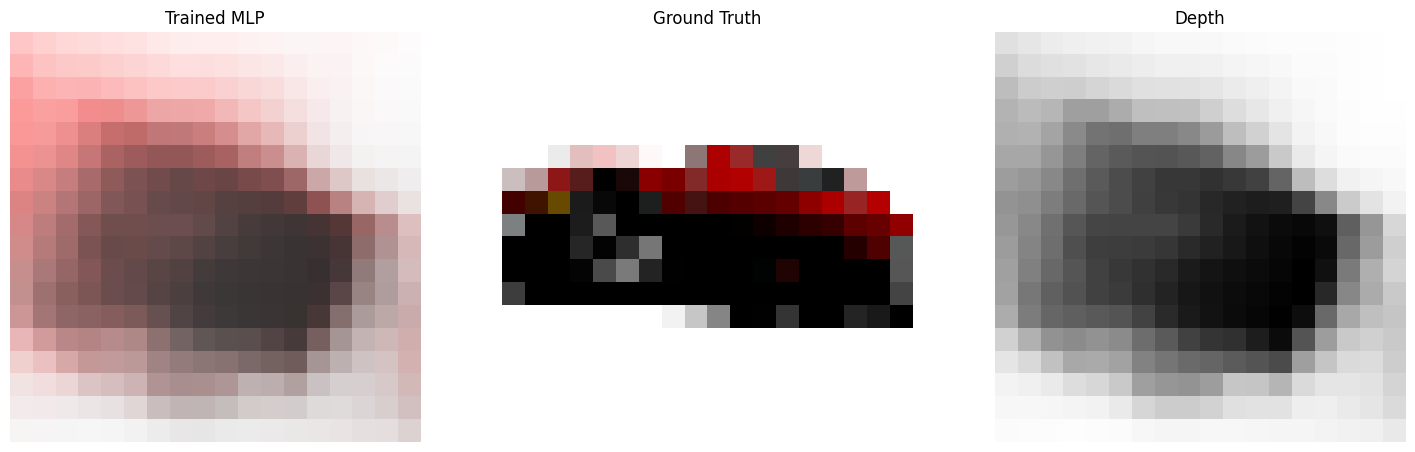

391
392
393
394
395
396
397
398
399
400
Step 400: loss = 0.11982


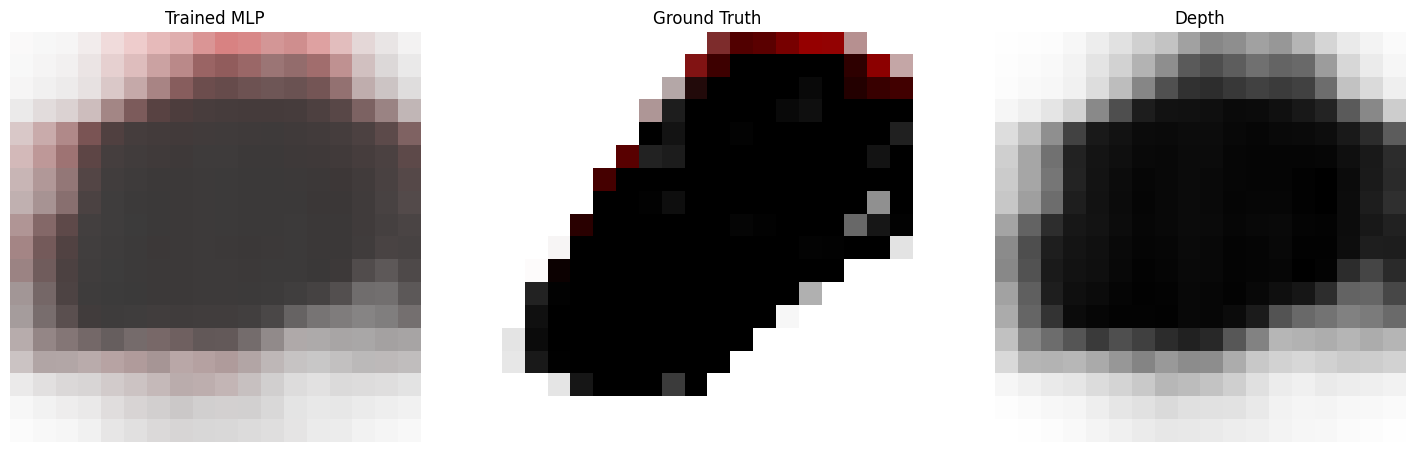

401
402
403
404
405
406
407
408
409
410


In [9]:
######## TODO
# Test dataset
sl = 18
dataset = SRNsCars(f'{root_dir}',max_num_instances=1, img_sidelength=sl)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4)

# Configurations
optim = torch.optim.Adam(lr=1e-3, params=rf_and_renderer.parameters())

try:
    _ = fit(net,
        rf_and_renderer, 
        iter(data_loader), 
        loss_fn=mse_loss, 
        resolution=(sl, sl, 3), 
        plotting_function=plot_output_ground_truth, 
        optimizer=optim, 
        total_steps=500,
        steps_til_summary=10
        )
except Exception:
    print(traceback.format_exc())


In [7]:
tt = torch.rand([2,3,4])
tt1 = tt.reshape(6,4)
tt2 = tt1.reshape(2,3,4)

In [8]:
print(tt)
print(tt2)

tensor([[[0.3358, 0.3414, 0.0445, 0.9169],
         [0.8272, 0.6943, 0.3660, 0.4133],
         [0.3184, 0.9038, 0.8705, 0.4337]],

        [[0.7808, 0.4880, 0.1675, 0.4072],
         [0.6080, 0.1129, 0.4709, 0.9591],
         [0.8904, 0.8169, 0.0562, 0.8889]]])
tensor([[[0.3358, 0.3414, 0.0445, 0.9169],
         [0.8272, 0.6943, 0.3660, 0.4133],
         [0.3184, 0.9038, 0.8705, 0.4337]],

        [[0.7808, 0.4880, 0.1675, 0.4072],
         [0.6080, 0.1129, 0.4709, 0.9591],
         [0.8904, 0.8169, 0.0562, 0.8889]]])
